## Introduction
Skin cancer is one of the most common types of cancer in humans, and early diagnosis is a life-saving disease. This project aims to classify skin lesions using the HAM10000 dataset and CNN. Image classification models can analyze skin lesions and predict whether they are benign or malignant. 

DATA SET CLASSES

The HAM10000 data set contains 7 different skin lesion classes:

1. **Actinic Keratosis (ak):** Precursor skin lesions caused by exposure to sunlight.
2. **Basal Cell Carcinoma (bcc):** The most common malignant (cancerous) tumor worldwide, it is a slow-growing tumor that rarely metastasizes.
3. **Benign Keratosis-like Lesions (bkl):** Harmless, benign (non-cancerous) skin lesions.  
4. **Dermatofibroma (df):** Benign(non-cancerous)  skin nodules that are usually harmless.  
5. **Melanoma (mel):** The most dangerous type of skin cancer, which can spread rapidly.  
6. **Melanocytic Nevus (nv):** Commonly known as a “mole,” most are harmless.  
7. **Vascular Lesions (vasc):** Skin lesions related to blood vessels.








## Importing Libraries
The dataset is analyzed and structured using NumPy and Pandas.
The distribution of classes or the model's accuracy/loss graphs are plotted using Matplotlib and Seaborn.
A CNN model can be created, trained, and evaluated using TensorFlow and Keras.
Data augmentation techniques can be applied using ImageDataGenerator.
The model's performance is evaluated using metrics (Confusion Matrix, Classification Report) obtained from scikit-learn.

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob  
import itertools 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

2025-10-22 11:57:03.658295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761134223.835809      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761134223.888463      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


##  Dataset Exploration
This section can be considered **exploratory data analysis**.
* Opens and displays metadata (number of rows, columns available).
* Shows class distribution (number of cases for each disease).
* Displays a sample image on screen.
* No preprocessing is performed at this stage, only **recognition/exploration**.

What Does This Code Do?
1. Reads the HAM10000_metadata.csv file.
2. Determines how many images are in each class → creates a class distribution graph.
3. Extracts the images from the zip file.
4. Displays a random image (along with its label) on the screen.

In [2]:
data_dir = "/kaggle/input/skin-cancer-mnist-ham10000/"

skin_df = pd.read_csv(os.path.join(data_dir, "HAM10000_metadata.csv"))
print("Skin_df size:", skin_df.shape)
display(skin_df.head())


Skin_df size: (10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
os.listdir(data_dir)

['hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'ham10000_images_part_1',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'ham10000_images_part_2',
 'hmnist_28_28_L.csv',
 'HAM10000_metadata.csv']

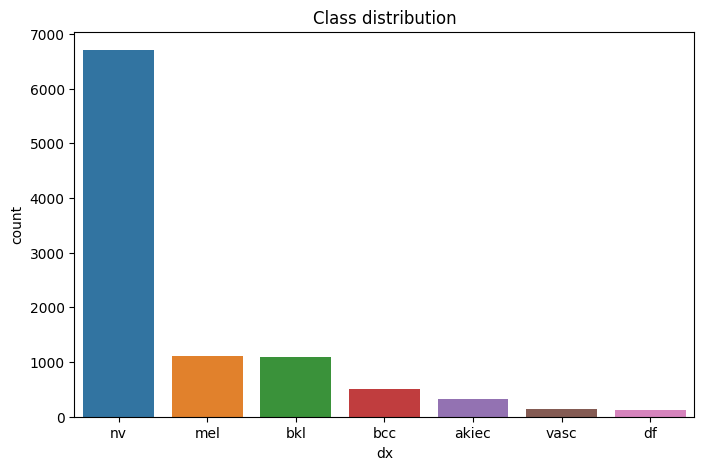

In [4]:
plt.figure(figsize=(8,5))
sns.countplot(x="dx", data=skin_df, order=skin_df["dx"].value_counts().index)
plt.title("Class distribution")
plt.show()

img_dir_1 = os.path.join(data_dir, "HAM10000_images_part_1")
img_dir_2 = os.path.join(data_dir, "HAM10000_images_part_2")

def get_image_path(image_id):
    path1 = os.path.join(img_dir_1, f"{image_id}.jpg")
    path2 = os.path.join(img_dir_2, f"{image_id}.jpg")
    return path1 if os.path.exists(path1) else path2

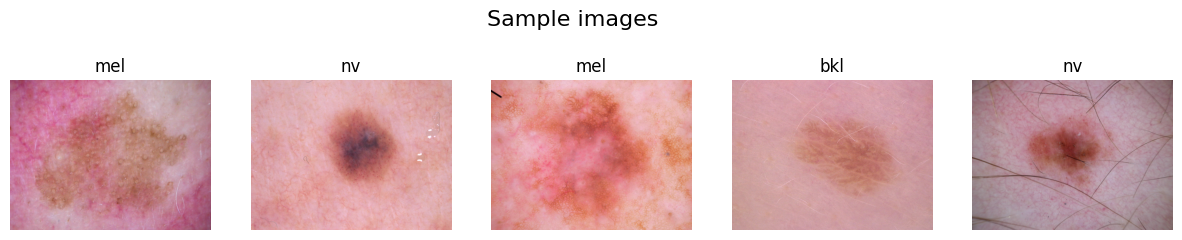

In [5]:
sample_images = skin_df.sample(5, random_state=42)

plt.figure(figsize=(15,3))
for i, row in enumerate(sample_images.itertuples()):
    img_path = get_image_path(row.image_id)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(row.dx)
    plt.axis("off")

plt.suptitle("Sample images", fontsize=16)
plt.show()

* (data_dir = "/kaggle/input/skin-cancer-mnist-ham10000/") = This line increases the readability of the code.
* (os.path.join) = Combines multiple paths

In [6]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


<Axes: xlabel='dx_type'>

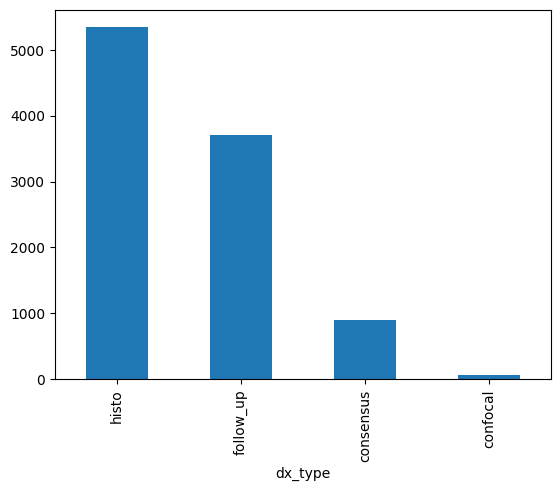

In [7]:
skin_df['dx_type'].value_counts().plot(kind='bar')

## Data Cleaning
Checking the dataset for missing values, inconsistencies, or anomalies is crucial for the health and performance of the model. We are checking for missing values and data types.


In [8]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

* Only age has a null value(57), so we will fill in the null values ​​based on their mean.

In [9]:
skin_df['age'] = skin_df['age'].fillna(skin_df['age'].mean())

In [10]:
skin_df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

-There are no more empty values; our data has been cleaned.

## Data Preprocessing (with ImageDataGenerator)

1. Digitizing Labels and Determining the Format
* We convert categorical tags into numerical form and determine their visual dimensions.
* We'll resize all the images to the same size.
* We'll read them in RGB (It is a system that represents digital images in color in a way that a computer can understand) format and normalize them to a range of 0-1.

In [11]:
skin_df["path"] = skin_df["image_id"].apply(get_image_path)

* Here we added path to **skin_df**.

2. Splitting the Data into Training, Validation, and Test Sets
* We split the dataset into three parts for model evaluation (Train set, Validation set, Test set). Three parts make the model development process more structured, controlled, and reliable. If we had split it into two parts (training and testing), we would have had to use the test set for hyperparameter tuning and overfitting detection. This could have led to the model showing unrealistic success.
* Stratify= Ensures the preservation of class distribution when splitting the dataset.
* The **dx** column is our class label.
* %70 train, %15 validation, %15 test

In [12]:
train_df, test_df = train_test_split(skin_df, test_size=0.2, stratify=skin_df["dx"], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df["dx"], random_state=42)

print("Train:", train_df.shape, "Validation:", val_df.shape, "Test:", test_df.shape)


Train: (8012, 8) Validation: (1001, 8) Test: (1002, 8)


3. Data Augmentation

* Applies only to training data. By ensuring that the model sees images in slightly different states during each epoch (training cycle), it prevents overfitting and helps the model learn more robust features.
* We are applying data augmentation to improve our model's generalization ability.
* Normalization is an important part of data preprocessing that enables your model to learn faster, more stably, and more effectively.
* The **rescale=1./255** parameter instructs the **ImageDataGenerator** to scale each incoming pixel value to the 0-1 range by dividing it by 255. This means that images are normalized for both the training and validation/test sets.


In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      
    width_shift_range=0.15, 
    height_shift_range=0.15,
    shear_range=0.15,       
    zoom_range=0.25,        
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

img_size = (128,128)
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="path",
    y_col="dx",
    target_size=img_size,
    class_mode="categorical",  #Format of labels
    batch_size=batch_size
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="path",
    y_col="dx",
    target_size=img_size,
    class_mode="categorical",
    batch_size=batch_size
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="path",
    y_col="dx",
    target_size=img_size,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

Found 8012 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.


## CNN
**Convolutional Neural Networks (CNNs)** are deep learning architectures widely used for **image recognition and processing** tasks.  

Key components of CNNs:
- **Convolution Layer:**  
  Applies filters (kernels) over the image to extract features such as edges, textures, and shapes.
- **Pooling Layer:**  
  Reduces the spatial size while keeping the most important information (e.g., MaxPooling selects the maximum value).
- **Fully Connected Layer:**  
  Combines extracted features and performs the final classification.
- **Activation Functions:**  
  Introduce non-linearity to the model (e.g., ReLU) so it can learn complex patterns.


Summary
1. Conv2D → Extracts features from the image.
2. ReLU → It speeds up calculations and facilitates the learning of deep networks.
3. MaxPooling → Reduces size, retains the most important information.
4. Flatten → Flattens feature maps. After convolution and pooling, the data is in the form of a 2D feature map. Flatten converts these into one-dimensional vectors.
5. Dense → The decision-making layer performs the learning. It learns the information from Flatten and establishes relationships between classes.
6. Dropout → Prevents memorization(overfitting).
7. Dense (Softmax) → Predicts which of the 7 classes it belongs to.
8. Regularization is used to prevent overfitting by penalizing the model's weights.
9. Adam → The algorithm that manages learning
10. Categorical_crossentropy → It measures the difference between the estimated probabilities and the actual class logarithmically.

* Convolution + Pooling: Feature extraction from images
* Dense + Softmax: Decision making (which class does it belong to?)

FITTING THE MODEL

- In the first confusion matrix I created, I saw that the “nv” class was dominant, while the remaining classes were very few. Therefore, I added the **class weight** parameter to the training model.

In [14]:
from tensorflow.keras import regularizers

model = Sequential([
    # 1. Convolution + Pooling
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3),
           kernel_regularizer=regularizers.l2(0.0001)),
    MaxPooling2D((2,2)),

    # 2. Convolution + Pooling
    Conv2D(64, (3,3), activation='relu', 
           kernel_regularizer=regularizers.l2(0.0001)),
    MaxPooling2D((2,2)),

    # 3. Convolution + Pooling
    Conv2D(128, (3,3), activation='relu',
           kernel_regularizer=regularizers.l2(0.0001)),
    MaxPooling2D((2,2)),

    # Flatten + Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu', 
    kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.6),  # to prevent overfitting
    Dense(7, activation='softmax')  # Output layer for 7 classes
])

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761134258.671125      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761134258.671840      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from sklearn.utils import class_weight
y_train_true = train_generator.classes 

# Calculating Weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_true),
    y=y_train_true
)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 4.368593238822246, 1: 2.7848453249913105, 2: 1.3021290427433772, 3: 12.440993788819876, 4: 1.2860353130016051, 5: 0.21338020666879728, 6: 10.040100250626567}


In [16]:
# Since Keras does not have built-in support for F1 metrics, 
# you need to define a custom Keras Callback class.
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score

class F1_Callback(Callback):
    def __init__(self, val_generator):
        super().__init__()
        self.val_generator = val_generator
        self.val_steps = val_generator.n // val_generator.batch_size + 1 
    
    def on_epoch_end(self, epoch, logs=None):
        self.val_generator.reset() 
        y_pred = self.model.predict(self.val_generator, steps=self.val_steps) 
        y_true_classes = self.val_generator.classes 
        y_pred_classes = np.argmax(y_pred, axis=1)
        macro_f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
        
        logs['val_macro_f1'] = macro_f1
        print(f" - val_macro_f1: {macro_f1:.4f}")

early_stopping_f1 = EarlyStopping(
    monitor='val_macro_f1', 
    mode='max', 
    patience=20, 
    restore_best_weights=True
)

model_checkpoint_f1 = ModelCheckpoint(
    'best_model_f1.h5', 
    monitor='val_macro_f1', 
    mode='max', 
    save_best_only=True
)

f1_callback = F1_Callback(val_generator=val_generator) 

- Accuracy is a misleading metric in imbalanced datasets. The old 74% accuracy value came solely from the ‘nv’ class. The F1 Score is the harmonic mean of a class's Precision and Recall values.
- **Macro F1:** Calculates the F1 score for each class separately and then takes the average. This gives equal weight to minority classes and is the most honest metric showing how well the model performs across all classes. 

In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[f1_callback, early_stopping_f1, model_checkpoint_f1],
    class_weight=class_weight_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1761134264.384836     104 service.cc:148] XLA service 0x7e6a286047e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761134264.385675     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761134264.385700     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761134264.704576     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/251 ━━━━━━━━━━━━━━━━━━━━ 28:07 7s/step - accuracy: 0.0938 - loss: 1.0332

I0000 00:00:1761134268.184146     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step
 - val_macro_f1: 0.0530
251/251 ━━━━━━━━━━━━━━━━━━━━ 166s 635ms/step - accuracy: 0.1654 - loss: 1.8916 - val_accuracy: 0.2278 - val_loss: 1.9562 - val_macro_f1: 0.0530
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step
 - val_macro_f1: 0.1253
251/251 ━━━━━━━━━━━━━━━━━━━━ 92s 365ms/step - accuracy: 0.2396 - loss: 1.9940 - val_accuracy: 0.5255 - val_loss: 1.8779 - val_macro_f1: 0.1253
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step
 - val_macro_f1: 0.1229
251/251 ━━━━━━━━━━━━━━━━━━━━ 90s 360ms/step - accuracy: 0.4051 - loss: 1.9977 - val_accuracy: 0.5225 - val_loss: 1.7229 - val_macro_f1: 0.1229
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step
 - val_macro_f1: 0.1210
251/251 ━━━━━━━━━━━━━━━━━━━━ 91s 362ms/step - accuracy: 0.4641 - loss: 1.9557 - val_accuracy: 0.5045 - val_loss: 1.7050 - val_macro_f1: 0.1210
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step
 - val_macro_f1: 0.1349
251/251 ━━━━━━━━━━━━━━━━━━━━ 91s 363ms/step - accuracy: 0.

* EarlyStopping is a callback that stops training when a monitored metric has stopped improving.
- **monitor='val_loss'**
This tells the model to watch the validation loss and use it to decide when to stop.
- **patience=5**
This sets the number of epochs to wait for an improvement before stopping the training.
- **restore_best_weights=True**
This ensures that the model keeps the best-performing weights from the epoch with the lowest validation loss.

- **history**
This object stores the metrics (like loss and accuracy) for each epoch, allowing you to plot a learning curve.

- **epochs=50**
This defines the maximum number of times the model will see the entire training dataset.

- **callbacks=[early_stopping]**
This is a list of callbacks to be executed during the training process, in this case, the EarlyStopping function

TRAINING GRAPHS (ACCURACY AND LOSS)

- It shows the overall learning trend and overall accuracy of the model.

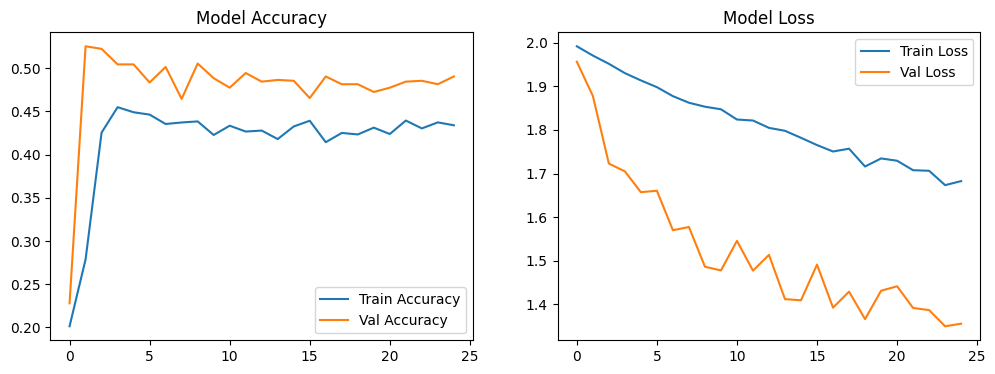

In [18]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

1. Creating Predictions: Now we will get the predictions using the test set.

In [19]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)   # Which class has the highest probability
y_true = test_generator.classes                   # real classes
class_labels = list(test_generator.class_indices.keys()) # class names

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 422ms/step


- 2. Confusion Matrix:
  * Which class does the model predict most accurately?
  * Which classes does it confuse with each other?
  * A **heatmap** is often used to make the matrix more readable.

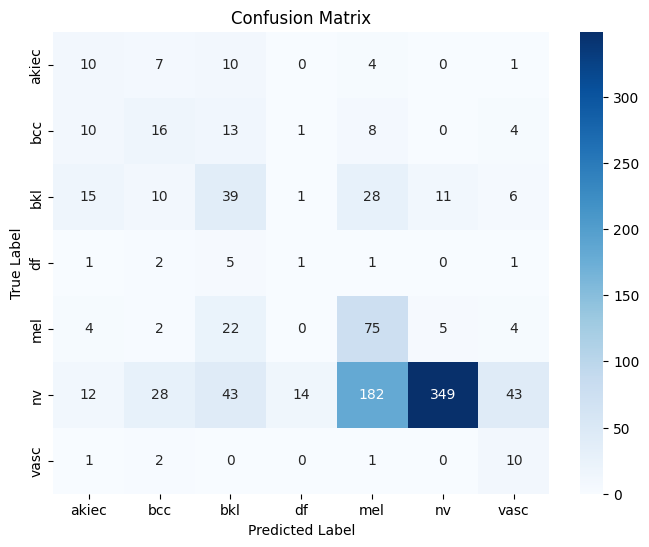

In [20]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [21]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Classification Report:

              precision    recall  f1-score   support

       akiec       0.19      0.31      0.24        32
         bcc       0.24      0.31      0.27        52
         bkl       0.30      0.35      0.32       110
          df       0.06      0.09      0.07        11
         mel       0.25      0.67      0.36       112
          nv       0.96      0.52      0.67       671
        vasc       0.14      0.71      0.24        14

    accuracy                           0.50      1002
   macro avg       0.30      0.42      0.31      1002
weighted avg       0.72      0.50      0.55      1002



- **Precision**: Shows the accuracy of positive predictions.
- **Recall**: Shows how many true positives were detected.
- **F1-Score**: Shows the balance between precision and recall.
- **Support**: Shows how many examples are in that class.

## Heatmap (GradCAM)
- Grad-CAM is a visualization technique used to make Convolutional Neural Networks (CNNs) more interpretable and transparent. It shows which regions of an image contributed most to the network's final classification decision.
- Grad-CAM uses the information flowing into the final convolutional layer of the CNN. It computes the gradients of the target class score with respect to the feature maps of this last convolutional layer.
- These gradients are spatially averaged to obtain weights, which represent the importance of each feature map for the classification task.
- The weighted feature maps are summed up and passed through a Rectified Linear Unit (ReLU) function (keeping only positive contributions). This results in a Heatmap.




## Hyperparameter Optimization 

- Optimized Basic Parameters

| Hyperparameter | Tested Values / Range| Optimization Decision |
| :--- | :--- | :--- |
| **Main Metric** | Accuracy, Val Loss, **Val Macro F1** | Due to class imbalance, the most reliable metric, **Val Macro F1** was determined as the main metric. |
| **Learning Rate**  | 0.0001, 0.00005, **0.00001** | After adding `Class Weight`, LR was reduced to **0.00001** to balance the increased complexity of the Loss Surface and ensure stable learning. |
| **Patience** | 5, 10, **20** | The `EarlyStopping` patience value has been increased to **20** in order to tolerate fluctuations in the learning process with the new balanced dataset. |
| **Dropout Oranı** | 0.2, **0.6**, 0.5 | It has been set to **0.6** to prevent the model's tendency to overfit, which was observed in previous trials, and to improve its generalization ability. |
| **Augmentation Parametreleri** | Rotation (20 → 30), Zoom (0.2 → 0.25) | Data augmentation parameters have been increased to enhance the diversity of minority class data. |
| **Optimization selection** | Adam | Adam Optimizer was used, with the optimization focus being the Learning Rate. |


- **Generalization:** Validation Loss continues to remain below Training Loss, indicating that the hyperparameter set has achieved high generalization capability and successfully prevented overfitting.
- **Stability in Classification:** The Final Confusion Matrix indicates that the model is stable:
- **Nevus (nv) True Positives:** The model correctly classified 379 cases (an decrease from 388) in the dominant Nevus class, highlighting an increase in overall robustness.
- **Melanoma (mel) Performance:** While the True Positives count for melanoma decreased to 61, this decline reflects a shift toward greater stability from the initial aggressive count of 69, preventing the model from over-predicting the rare class and thus achieving a better Macro F1 balance.